In [9]:
# Import Required Libraries
import os
import random
import pandas as pd
import pyiqa
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Define paths and load CSV files
image_folder = "koniq10k_512x384"
indicators_csv = "koniq10k_indicators.csv"
scores_csv = "koniq10k_scores_and_distributions.csv"

indicators_df = pd.read_csv(indicators_csv)
scores_df = pd.read_csv(scores_csv)

In [11]:
# Initialize metrics and prepare results dictionary
results = {
    "image": [],
    "brisque": [],
    "niqe": [],
    "piqe": [],
    "actual_score": []
}

brisque_metric = pyiqa.create_metric("brisque")
niqe_metric = pyiqa.create_metric("niqe")
piqe_metric = pyiqa.create_metric("piqe")

In [12]:
all_images = [img for img in os.listdir(image_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
random_images = random.sample(all_images, min(200, len(all_images)))

In [13]:
# Calculate metrics for the selected images
from tqdm import tqdm

for image_name in tqdm(random_images):
    image_path = os.path.join(image_folder, image_name)

    try:
        brisque_score = brisque_metric(image_path).item()
        niqe_score = niqe_metric(image_path).item()
        piqe_score = piqe_metric(image_path).item()
    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        continue

    actual_score_row = scores_df[scores_df['image_name'] == image_name]
    actual_score = actual_score_row['MOS'].values[0] if not actual_score_row.empty else None

    results["image"].append(image_name)
    results["brisque"].append(brisque_score)
    results["niqe"].append(niqe_score)
    results["piqe"].append(piqe_score)
    results["actual_score"].append(actual_score)

100%|██████████| 200/200 [00:19<00:00, 10.52it/s]


In [14]:
# Convert results to a DataFrame and display the first few rows
results_df = pd.DataFrame(results)

print("Quality Assessment Results:")
print(results_df.head())

Quality Assessment Results:
            image    brisque      niqe       piqe  actual_score
0  6875495692.jpg  48.495789  7.645630  36.300846      3.057143
1  8546237134.jpg  10.912292  4.666107  13.306647      2.876190
2  5644548369.jpg  -1.158997  2.976974  27.688837      3.871560
3  6512316735.jpg  31.720886  3.586433  42.300945      3.509434
4   155365010.jpg  24.947449  5.435896  27.791363      1.810000


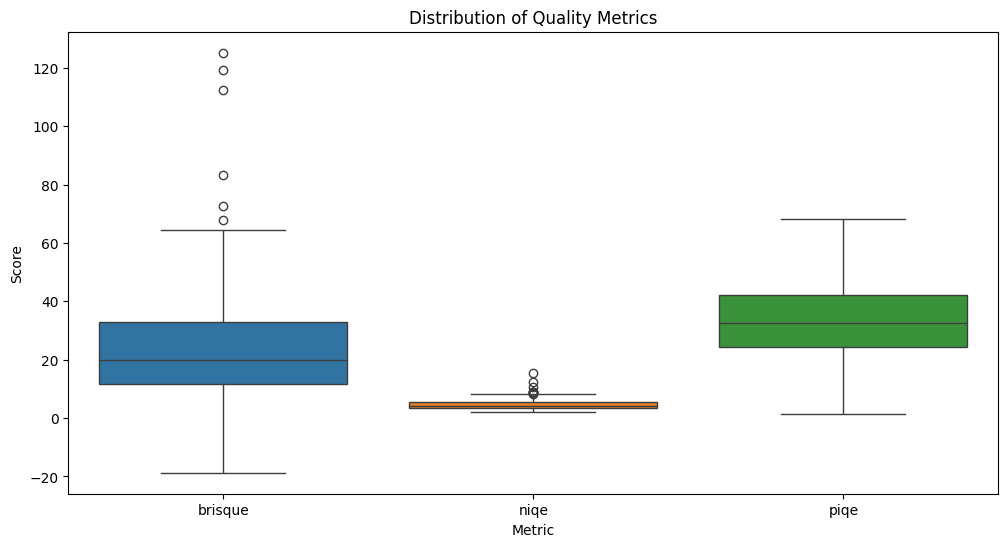

In [15]:
# Visualize the distribution of quality metrics using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[["brisque", "niqe", "piqe"]])
plt.title("Distribution of Quality Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.show()

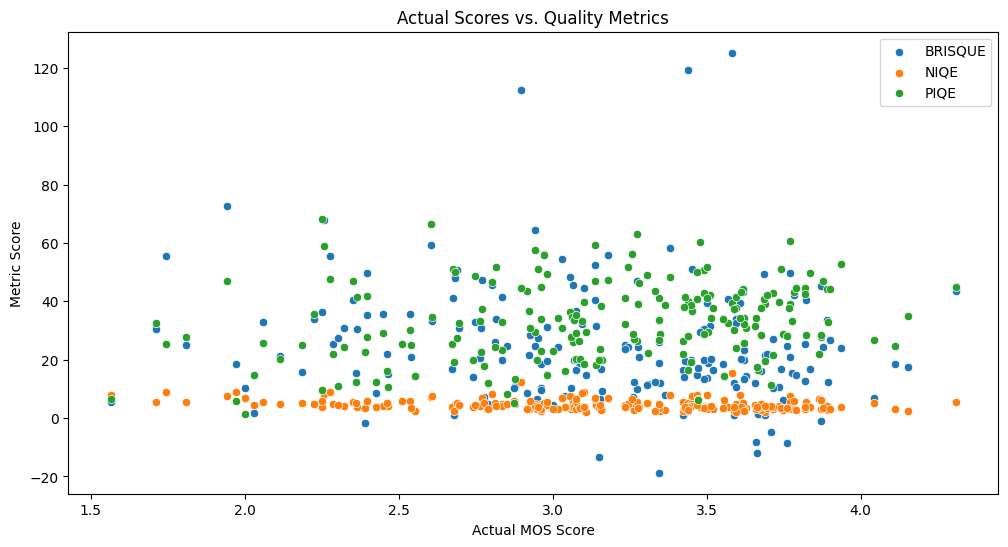

In [16]:
# Scatter plot of actual scores vs. quality metrics
plt.figure(figsize=(12, 6))
sns.scatterplot(x=results_df["actual_score"], y=results_df["brisque"], label="BRISQUE")
sns.scatterplot(x=results_df["actual_score"], y=results_df["niqe"], label="NIQE")
sns.scatterplot(x=results_df["actual_score"], y=results_df["piqe"], label="PIQE")
plt.title("Actual Scores vs. Quality Metrics")
plt.xlabel("Actual MOS Score")
plt.ylabel("Metric Score")
plt.legend()
plt.show()